In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys 
import mdtraj

NFF_PATH = '/home/wwj/Repo/playgrounds/NeuralForceField/'
ODE_PATH = '/home/wwj/Repo/projects/torchdiffeq/'

sys.path.insert(0, NFF_PATH)
sys.path.insert(0, ODE_PATH)
sys.path.insert(0, '../..')

import torch
from torch.optim import Adam
from torchdiffeq import odeint_adjoint as odeint
from torchmd.ode import ODE
from torchmd.hamiltoinians import PairPot, MLP, LennardJones, leps
from torchmd.observable import DiffRDF
from torchmd.utils import dump_mov
from nglview import show_ase, show_file, show_mdtraj

from nff.utils.scatter import compute_grad
from nff.nn.layers import GaussianSmearing
from ase import Atoms

import matplotlib
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rc('lines', linewidth=4, color='g')
matplotlib.rcParams['axes.linewidth'] = 3.0

import matplotlib.cm as cm

In [6]:
def plot_lesp(model, traj, res=50, start=[3.5, 0.8], end=[0.8, 3.5], fname=None):
    xlist = np.linspace(0.5, 5.0, res)
    ylist = np.linspace(0.5, 5.0, res)
    X, Y = np.meshgrid(xlist, ylist)

    data = torch.Tensor(np.concatenate((X[:,:, None],Y[:,:,None]), axis=2).reshape(-1,2))
    E = np.array(model(data)).reshape(res, res)
    
    plt.figure(figsize=(7,7))
    cp = plt.contourf(X, Y, E, 40, cmap='GnBu', alpha=0.4)
    plt.colorbar(cp)

    traj = traj.detach().cpu().numpy()
    colors = cm.rainbow(np.linspace(0, 1, traj.shape[0]))
    
    for i,c in enumerate(colors):

        plt.scatter(traj[i, 2], traj[i, 3], color=c, s=1)
        
    plt.scatter(start[0], start[1], c='red')
    plt.scatter(end[0], end[1], c='red')
    
    plt.xlim((0.5, 5.0))
    plt.ylim((0.5, 5.0))
    
    if fname is not None:
        plt.savefig(fname)
    
    plt.show()


inital vel [-0.45865038 -0.2882445 ]
118
tensor([20.1704,  0.7029, 10.4510, -7.8107], device='cuda:0') 37.21220397949219


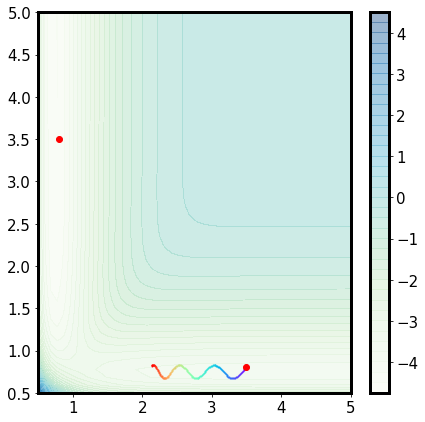

inital vel [-1.4994084  -0.35562846]
114
tensor([-1.4425,  0.7396,  3.7175,  2.1265], device='cuda:0') 20.759302139282227


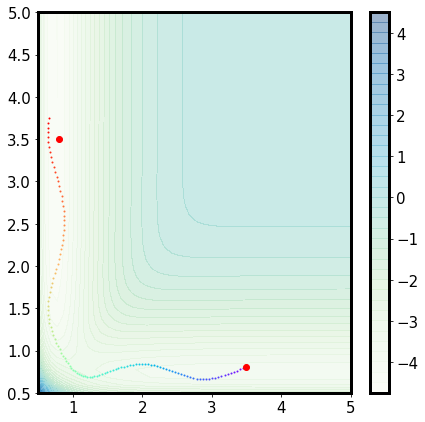

inital vel [-1.4250576 -0.3903821]
119
tensor([9.1485, 1.1865, 6.8394, 5.7303], device='cuda:0') 20.859516143798828


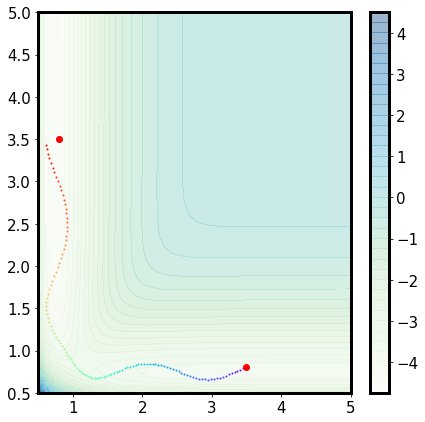

inital vel [-1.9027488  -0.46997422]
101
tensor([  8.6655,  -1.9260,   8.9709, -16.7689], device='cuda:0') 18.727441787719727


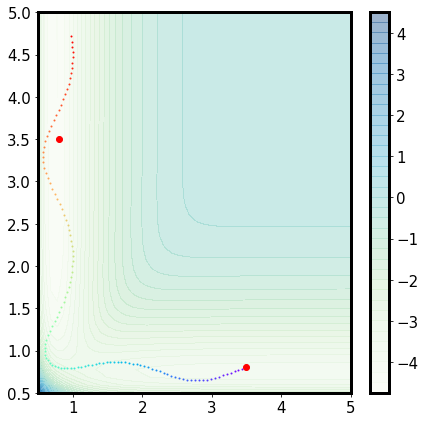

inital vel [-2.3238726 -0.3615238]
91
tensor([  3.2938,   1.2011,   5.7116, -11.2459], device='cuda:0') 15.811554908752441


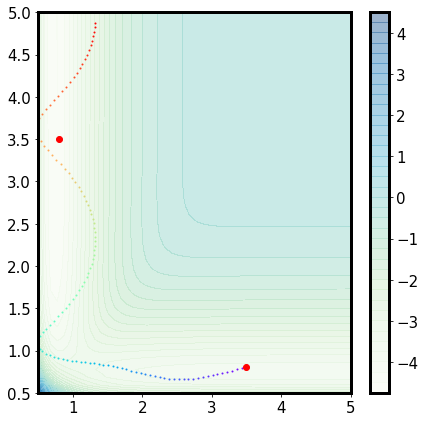

inital vel [-2.4957006  -0.42871812]
91
tensor([-2.1720, -1.8627,  6.5006,  2.1930], device='cuda:0') 15.657201766967773


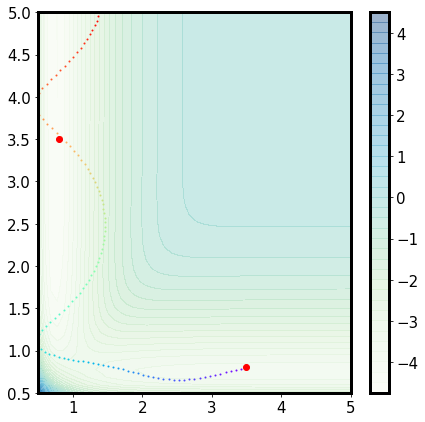

inital vel [-2.3855977  -0.33408046]
90
tensor([ 2.0468,  1.2205,  5.2386, -8.9163], device='cuda:0') 15.677386283874512


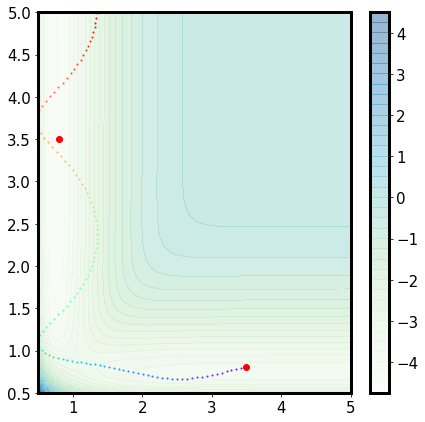

inital vel [-2.491288   -0.39845452]
91
tensor([-1.4421, -0.8172,  5.9077, -0.0798], device='cuda:0') 15.60917854309082


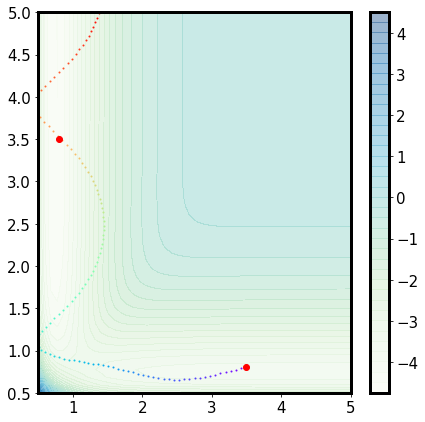

inital vel [-2.4198606  -0.35827234]
90
tensor([ 1.1004,  0.6892,  5.4653, -5.7800], device='cuda:0') 15.599276542663574


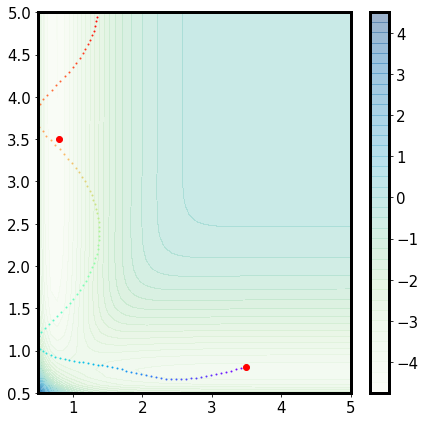

inital vel [-2.4760983  -0.39394587]
90
tensor([-0.8728, -0.7208,  6.0341, -0.6082], device='cuda:0') 15.588178634643555


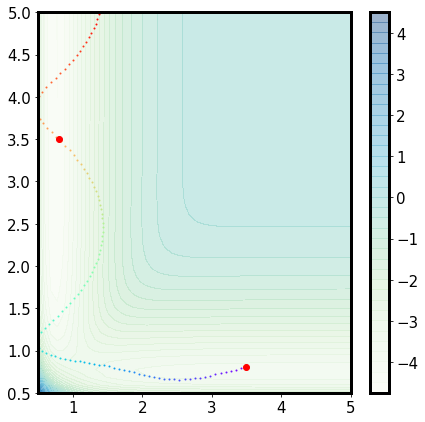

In [10]:
DEVICE = 0 

u = leps()
targ_x = torch.Tensor([0.8, 3.5]).to(DEVICE)
mass = np.ones(1)

p = (torch.rand(2) - 1.0) * 0.5#.to(DEVICE)
q = torch.Tensor([3.5, 0.8])#.to(DEVICE) 

for i in range(0, 10):
    
    if i == 0:
        dp = torch.Tensor([0., 0.])
    elif pq.grad is not None:
        update = pq.grad[:2].detach().cpu() * 5e-2
        dp = update + (torch.rand(1) - 0.5)* 0.1 * update.pow(2).sum(-1).sqrt() # adding noise to the gradient 
    else:
        dp = torch.Tensor([0., 0.])
    
    # gradient descent 
    p -= dp
    print("inital vel", p.detach().cpu().numpy())

    t = torch.Tensor([0.03* i for i in range(120)]).to(DEVICE)
    t.requires_grad=True

    pq = torch.cat((p, q)).to(DEVICE)
    pq.requires_grad = True

    f_x =  ODE(u, mass, dim=2, device=DEVICE) 
    x = odeint(f_x, pq, t , method='rk4' )
    
    # get the closest index 
    cls_idx = (x[:, 2:] - targ_x).pow(2).sum(-1).argmin(0)

    # control initial velocities 
    print(cls_idx.item())
    
    band = u(x[:, 2:]) # get the energy band 
    max_idx = band.argmax()  # get the idx of the highest band 
    
    dev_1 = (x[::10, 2:] - targ_x).pow(2).sum() # get the average distance between the target and middle steps
    dev = (x[cls_idx][2:] - targ_x).pow(2).sum() # get the distance between the closest step and the target 
    final_vel = x[-1, :2].pow(2).sum() # final velocity 
    loss = dev + dev_1 * 0.2 + final_vel 
    loss.backward()
    
    print(pq.grad, loss.item())

    # plot trajectory for making GIF later
    if i <= 10:
        plot_lesp(u, x, fname='./0{}.png'.format(i))
    else:
        plot_lesp(u, x, fname='./{}.png'.format(i))

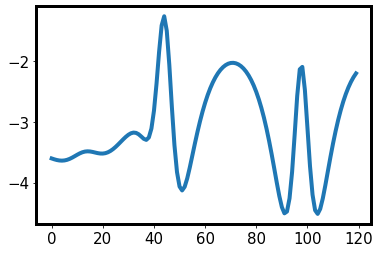

In [11]:
# visualize the band, the highest point may not be the saddle points
plt.plot( u(x[:, 2:]).detach().cpu())